In [1]:
import numpy as np 
from matplotlib import pyplot as plt 
import scipy.io as sio

from utils import *
from generateData import generateSynthData
from src.data import datagen as dg
from src.measurements import *
from src.covarianceRecovery import *

/storage/home/hcoda1/8/msethuraman7/p-ff14-0/miniconda3/envs/cov-rec/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
n_nodes=100
data_gen = dg.Dataset(n_nodes=n_nodes, 
                      expected_density=1,
                      n_samples=5000,
                      n_experiments=100,
                      min_targets=5,
                      max_targets=5,
                      mode='block-node')
datasets = data_gen.generate()
intervention_sets = data_gen.targets

In [36]:
intervention_sets[0]

array([0, 1, 2, 3, 4])

In [15]:
weights = data_gen.gen_model.weights

In [2]:
weights = np.load("../pref_req_data/ground_truth/weights.npy")

In [3]:
intervention_sets = np.load("../pref_req_data/ground_truth/intervention_sets.npy", allow_pickle=True)

In [4]:
datasets = [
    np.load('../pref_req_data/ground_truth/datasets/dataset_{}.npy'.format(i)) for i in range(len(intervention_sets))
]

In [53]:
for i in range(len(intervention_sets)):
#     observed_set = np.setdiff1d(np.arange(n_nodes), intervention_sets[i])
#     U = np.zeros((n_nodes, n_nodes))
#     U[observed_set, observed_set] = 1
    
#     Cov_X_int = np.linalg.inv(np.eye(n_nodes) - U@weights.T) @ np.linalg.inv(np.eye(n_nodes) - U@weights.T).T
    np.save('../pref_req_data/ground_truth/datasets/dataset_{}.npy'.format(i), datasets[i])

In [67]:
n_nodes = 100
observed_set = np.setdiff1d(np.arange(n_nodes), intervention_sets[2])
U = np.zeros((n_nodes, n_nodes))
U[observed_set, observed_set] = 1

W = weights
Cov_X = np.linalg.inv(np.eye(n_nodes) - U@W.T) @ np.linalg.inv(np.eye(n_nodes) - U@W.T).T


In [68]:
indices = np.concatenate((intervention_sets[2], observed_set))
col_ind_r, row_ind_r = np.meshgrid(indices, indices)

Cov_X_r = Cov_X[row_ind_r, col_ind_r]

<IPython.core.display.Javascript object>


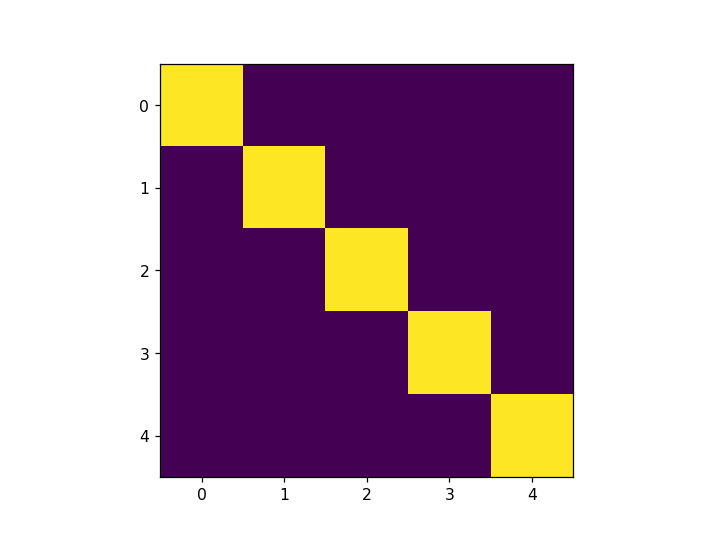

In [61]:
%matplotlib notebook

plt.imshow(Cov_X_r[:5, :5])

Sensing matrix shape: (35, 100)


<IPython.core.display.Javascript object>


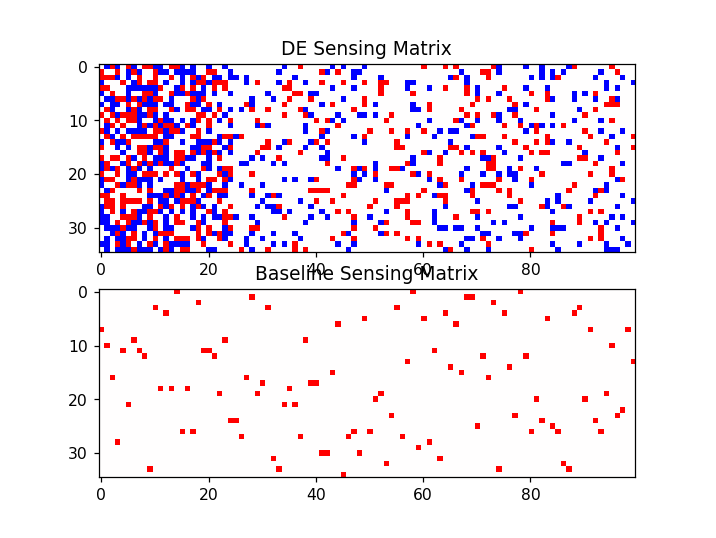

Text(0.5, 1.0, 'Baseline Sensing Matrix')

In [76]:
lambda_h = sio.loadmat("lambda_h_3.mat")['lambda_h']
lambda_l = sio.loadmat("lambda_l_3.mat")["lambda_l"]

A = getSensingMatrixUP(lambda_h, lambda_l, dch=15, dcl=15, nh=25, nl=75, A=1.0)
A_bs = generateA(A.shape[0], A.shape[1], delta=1)
print("Sensing matrix shape: {}".format(A.shape))

%matplotlib notebook

fig, axs = plt.subplots(2, 1)

im = axs[0].imshow(A, cmap='bwr', vmin=-1, vmax=1)
axs[0].set_title("DE Sensing Matrix")
im = axs[1].imshow(A_bs, cmap='bwr', vmin=-1, vmax=1)
axs[1].set_title("Baseline Sensing Matrix")
# cbar = plt.colorbar(im)

In [75]:
A = np.load("../pref_req_data/sensing_matrix_de.npy")
A_bs = np.load("../pref_req_data/sensing_matrix_bs.npy")

In [28]:
np.save("../pref_req_data/sensing_matrix_de.npy", A)
np.save("../pref_req_data/sensing_matrix_bs.npy", A_bs)

In [13]:
intervention_path = '../pref_req_data/intervention_0'

Y_cov_list = list()
for 

SyntaxError: invalid syntax (3104305388.py, line 4)

In [6]:
Y_cov_int_list, indices_int_list = makeMeasurements(A, datasets, intervention_sets, nh=25)
Y_cov_int_list_bs, indices_int_list_bs = makeMeasurements(A_bs, datasets, intervention_sets, nh=25)

In [12]:
import os
for i in range(len(intervention_sets)):
    path = "../pref_req_data/de_measurements/inter_{}".format(i)
    if not os.path.exists(path):
        os.makedirs(path)
    count = 0
    for Y_cov, ind_list in zip(Y_cov_int_list[i], indices_int_list[i]):
        np.save(os.path.join(path, "Y_cov_{}.npy").format(count), Y_cov)
        np.save(os.path.join(path, "ind_set_{}.npy").format(count), ind_list)
        count += 1
        

In [14]:
for i in range(len(intervention_sets)):
    path = "../pref_req_data/bs_measurements/inter_{}".format(i)
    if not os.path.exists(path):
        os.makedirs(path)
    count = 0
    for Y_cov, ind_list in zip(Y_cov_int_list_bs[i], indices_int_list_bs[i]):
        np.save(os.path.join(path, "Y_cov_{}.npy").format(count), Y_cov)
        np.save(os.path.join(path, "ind_set_{}.npy").format(count), ind_list)
        count += 1
        

In [11]:
len(indices_int_list[0])

5

In [77]:
nl = 75
nh = 25

X = datasets[2]
Y_list, indices_list = makeIntMeasurements(A, X, intervention_sets[2], nh)
Y_bs_list, _ = makeIntMeasurements(A_bs, X, intervention_sets[2], nh)

Sig_Y = Y_list[0]
Sig_Y_bs = Y_bs_list[0]

In [78]:
%%time
Cov_X_de_r = covarianceEstimateTorch(A, Sig_Y, pen_coeff=0.5)
Cov_X_bs_r = covarianceEstimateTorch(A_bs, Sig_Y_bs, pen_coeff=0.5)

CPU times: user 58.3 s, sys: 546 ms, total: 58.8 s
Wall time: 59.3 s


In [79]:
Cov_X_hh = Cov_X_r[:5, 5:nh]
Cov_x_hat_de_hh = Cov_X_de_r[:5, 5:nh]
Cov_x_hat_bs_hh = Cov_X_bs_r[:5, 5:nh]

In [81]:
print("DE Error, Fro: {}, MAE: {}".format(np.linalg.norm(Cov_X_hh - Cov_x_hat_de_hh, 'fro'), np.abs(Cov_X_hh - Cov_x_hat_de_hh).max()))
print("BS Error, Fro: {}, MAE: {}".format(np.linalg.norm(Cov_X_hh - Cov_x_hat_bs_hh, 'fro'), np.abs(Cov_X_hh - Cov_x_hat_bs_hh).max()))

DE Error, Fro: 0.6136218874948515, MAE: 0.38664567172749714
BS Error, Fro: 0.660650316914703, MAE: 0.5216183413575248


In [66]:
S_x = (1/nSamples) * X.T @ X 
S_x_hh = S_x[:nh, :nh]

print(np.linalg.norm(Cov_X_hh - S_x_hh, 'fro'))

NameError: name 'nSamples' is not defined

<IPython.core.display.Javascript object>


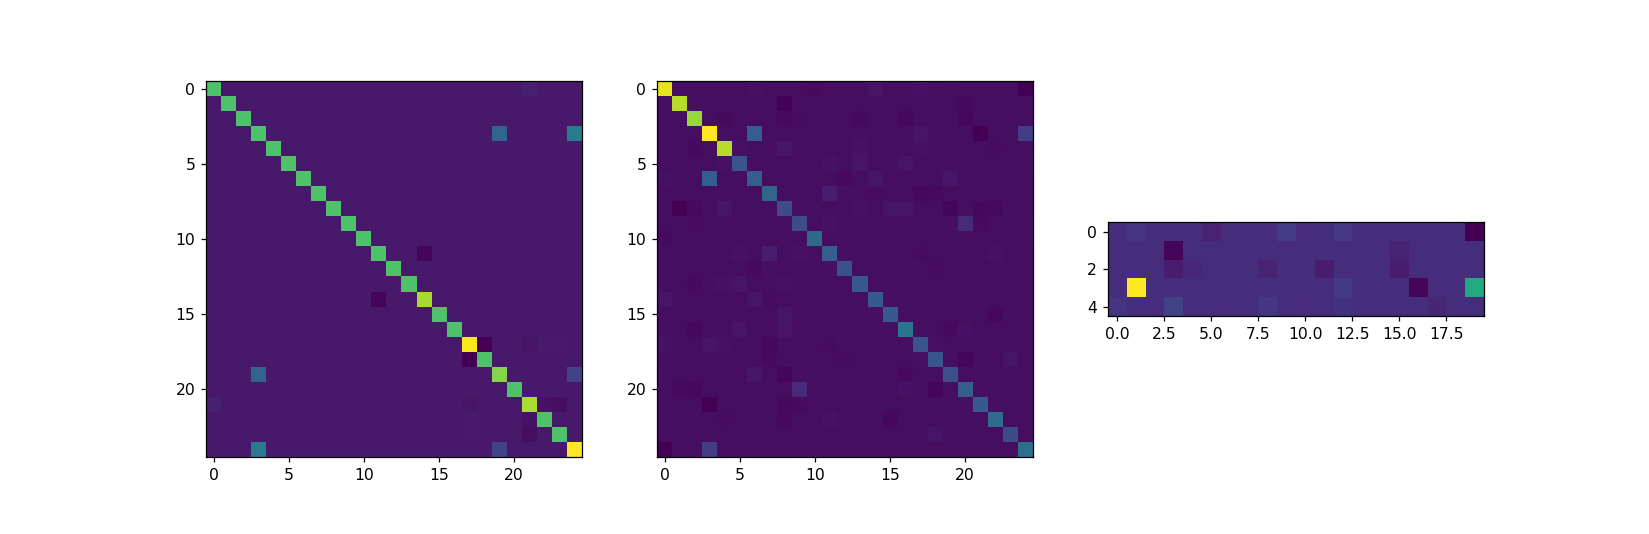

In [84]:
%matplotlib notebook

fig, axs = plt.subplots(1, 3)

axs[0].imshow(Cov_X_r[:nh, :nh])
axs[1].imshow(Cov_X_de_r[:nh, :nh])
axs[2].imshow(Cov_x_hat_de_hh)